In [10]:
import nltk, re, pprint
from nltk import word_tokenize
import os,json
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize 
import nltk.data
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize
import augur
import sqlalchemy as s
import matplotlib.pyplot as plot
import matplotlib.dates as mdates
import pandas as pd
%matplotlib inline
#nltk.download('punkt')
#nltk.download('stopwords')
#pip install twython
#nltk.download('vader_lexicon')

In [11]:
if("notebooks" not in os.getcwd()):
    os.chdir("notebooks")
augurApp = augur.Application('../augur.config.json')
connect = augurApp.ghtorrentplus()

In [12]:
table_names = s.inspect(connect.db).get_table_names()
print(table_names)

['github_issues', 'github_issues_sentiment_scores', 'issue_response_time', 'mail_lists', 'mailing_list_jobs']


In [13]:
if("mailing_list_jobs" in table_names):
    lists_createdSQL = s.sql.text("""SELECT project FROM mailing_list_jobs""")
    df1 = pd.read_sql(lists_createdSQL, connect.db)
    print(df1)
    val = True

          project
0      aalldp-dev
1      aalldp-dev
2  archetypes-dev
3  archetypes-dev


In [14]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sid = SentimentIntensityAnalyzer()
col = 'score','sentiment'
columns1 = 'augurmsgID', 'backend_name','project','mailing_list','category',\
           'message_part','message_parts_tot', 'subject','date',\
           'message_from','message_id','message_text'
df3 = pd.DataFrame(columns = col)
df_list = pd.DataFrame(columns = columns1)
for i in df1['project'].values:
    print(i,"Mailing List")
    SQL = s.sql.text("""SELECT * 
    FROM mail_lists WHERE mailing_list = """ +  "'" + i + "'")
    df2 = pd.read_sql(SQL, connect.db)
    df_list = df_list.append(df2)
    #print(df2)
    grouped = df2.groupby('message_id').groups
    print("Here!!!!")
    #print("\n\n","-"*70,"\n\n")
    for group in grouped:
        parts = 0
        numb = len(df2.loc[df2['message_id'] == group]['message_parts_tot'].tolist())
        message = (df2.loc[df2['message_id'] == group]['message_text']).tolist()
        message_text = ''.join(message)
        sentences = tokenizer.tokenize(message_text)
        compound = parts = 0
        sentiment = "Positive"
        for sentence in sentences:
            scores = sid.polarity_scores(sentence)
            compound+= scores['compound']
            parts+=1
        avg_score = compound/parts
        avg_score = round(avg_score,3)
        if(avg_score == 0):
            sentiment = "Neutral"
        elif(avg_score < 0):
            sentiment = "Negative"
        #print(message)
        for i in range(numb):
            li = [ [avg_score, sentiment] ]
            df_temp = pd.DataFrame(li,columns = col)
            #print(df_temp['score'])
            df3 = df3.append(df_temp)
            #print(df3)
    print("\n\n")

aalldp-dev Mailing List
Here!!!!



aalldp-dev Mailing List
Here!!!!



archetypes-dev Mailing List
Here!!!!



archetypes-dev Mailing List
Here!!!!





In [15]:
print(df3)
print(df_list)
df3 = df3.reset_index(drop=True)
df_list = df_list.reset_index(drop=True)
combine = (df_list.join(df3))

   score sentiment
0  0.271  Positive
0  0.271  Positive
0  0.345  Positive
0  0.345  Positive
0  0.031  Positive
0  0.031  Positive
0  0.140  Positive
0  0.140  Positive
0  0.625  Positive
0  0.625  Positive
0  0.271  Positive
0  0.271  Positive
0  0.345  Positive
0  0.345  Positive
0  0.031  Positive
0  0.031  Positive
0  0.140  Positive
0  0.140  Positive
0  0.625  Positive
0  0.625  Positive
0  0.148  Positive
0  0.148  Positive
0  0.286  Positive
0  0.286  Positive
0  0.148  Positive
0  0.148  Positive
0  0.286  Positive
0  0.286  Positive
  augurmsgID backend_name                                            project  \
0          1    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
1          2    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
2          3    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
3          4    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
4          5    Pipermail  https://lists.opendayl

In [16]:
print(combine)
print(list(combine))

   augurmsgID backend_name                                            project  \
0           1    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
1           2    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
2           3    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
3           4    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
4           5    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
5           6    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
6           7    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
7           8    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
8           9    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
9          10    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
10          1    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
11          2    Pipermail  

In [17]:
combine.to_sql(name='mail_lists_sentiment_scores',con=connect.db,\
               if_exists='replace',index=False)

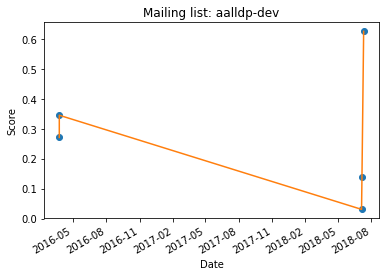

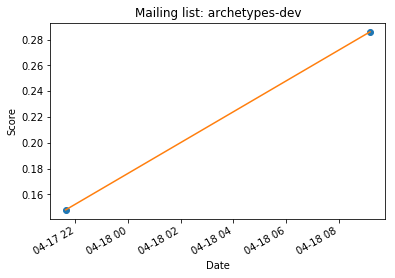

In [18]:
grouped = combine.groupby('mailing_list').groups
dates = []
values = []
mail_list = None
j = 0
for group in grouped:
    dates = (combine.loc[combine['mailing_list'] == group]['date']).tolist()
    values = (combine.loc[combine['mailing_list'] == group]['score']).unique().tolist()
    x = np.array(dates)
    dates = np.unique(x)
    #print(dates)
    dates1 = [x.to_pydatetime() for x in dates]
    dates2 = mdates.date2num(dates1)
    plot.plot_date(dates2, values)
    plot.plot(dates2,values)
    # beautify the x-labels
    plot.gcf().autofmt_xdate()
    plot.title("Mailing list: " + group)
    plot.ylabel('Score')
    plot.xlabel('Date')
    #plot.savefig('mailing_list' + str(j) + '.png')
    plot.show()
    j+=1

In [10]:
message_text = """Sarah Sharp recently posted a tirade about verbal abuse on here and 
her blog - where she dismisses all comments disagreeing with her as 
being from trolls, and deletes them - and takes pride in being 
"accidentally racist", when she's not attention-whoring on the LKML. 

I want to say, as a female developer: Sarah Sharp is not 
representative of us. She's not representative of the women at Intel. 
She's not representative of women in technology. 

She's a bully. She bullies her husband. She dismisses bullying of her 
coworkers. (Google: 'intel kick me'). And she's trying to bully Linus. 

I know he's a big boy. But dare I say, Linus is too nice to tell this 
drama queen to bugger off. 

No one was talking to her. Linus' 'Shut the fuck up' was to a 
developer who refused to take responsibility for his code, and blamed 
someone else's code. It was deserved criticism. Then, Linus went and 
explained just that: 

"Similarly, you will see fireworks if some long-term maintainer makes 
excuses for breaking user space etc. That will make me go into 
incoherent rages." 

Which is exactly what the emails held up as "verbal abuse" show. 

Sarah's exclaiming how she won't take any of this abuse, yet no one 
was directing any of it at her. It's sickening she's got nothing 
better to do then stick her nose in and decide to dictate to her 
betters how to behave. Yes I said her betters: We all run Linux. Not 
Sarax. 

Sarah justifies pissing in the Linux sandbox because Intel 'pays her' 
to develop kernel drivers. Perhaps her direct manager might rethink 
this decision in light of how she's representing Intel in her "off" 
time. 

To Linus: You're a hero to many of us. Don't change. Please. You DO 
NOT need to take time away from doing code to grow a pair of breasts 
and judge people's emotional states: 

"It does not matter if your cursing fits have causes. The fact is that 
if you misjudge someone's emotional state for the day, you yelling at 
them is not productive." 

As a woman, I couldn't be silent and stand by while Sarah bullied and 
assaulted this list with her profanity and self-indulgent narcissism. 
She's the problem. Not you. Not your style of communication. We 
technical women appreciate being treated equally by our male peers, 
with blunt directness and unambiguous criticism. We are not fragile flowers. 

We can do our jobs without demanding others interact with us on our 
terms and tiptoe around our fragile egos while being considerate of 
our ever changing emotional needs. 

I promise you, it's true. We're not all Sarah Sharps. 

I see a lot of the devs including Linus handling her with kid gloves 
to be diplomatic. Don't. If you want to be really nice, maybe drop an 
email to her direct manager extending an apology for how hurtful it 
was to her, having to observe others having a conversation in which 
she wasn't involved. Managers like hearing about that. 

We love you Linus, just the grumptastic way you are. Don't change how 
you interact, especially because of Sarah Sharp and her ilk. Please and 
thanks.. 
-- 
To unsubscribe from this list: send the line "unsubscribe linux-kernel" in 
the body of a message to majordomo@vger.kernel.org 
More majordomo info at http://vger.kernel.org/majordomo-info.html 
Please read the FAQ at http://www.tux.org/lkml/
"""

In [11]:
message_text = """_Dear reader from `${externalSource}`: I neither like nor support personal abuse or attacks. If you are showing up here getting angry at any party involved, I would ask you to refrain from targeting them, privately or in public. Specifically to people who think they may be supporting me by engaging in abusive behaviour: I do not appreciate, want or need it, in any form and it is not helpful in any way._

Yep, this is a long post, but no apologies for the length this time. Buckle up.

I'm sad that we have reached this point, and that the CTC is being asked to make such a difficult decision. One of the reasons that we initially split the TSC into two groups was to insulate the technical _doers_ on the CTC from the overhead of administrative and political tedium. I know many of you never imagined you'd have to deal with something like this when you agreed to join and that this is a very uncomfortable experience for you.

It's obvious that we never figured out a suitable structure that made the TSC a useful, functional, and healthy body that might be able to deal more effectively with these kinds of problems, more isolated from the CTC. I'm willing to accept a sizeable share of the blame for not improving our organisational structure during my tenure in leadership.

## My response

Regarding the request for me to resign from the CTC: in lieu of clear justification that my removal is for the benefit of the Node.js project, or a case for my removal that is not built primarily on hearsay and innuendo, I respectfully decline.

There are two primary reasons for which I am standing my ground.

I cannot, in good conscience, give credence to the straw-man version of me being touted loudly on social media and on GitHub. This caricature of me and vague notions regarding my "toxicity", my propensity for "harassment", the "systematic" breaking of rules and other slanderous claims against my character has no basis in fact. I will not dignify these attacks by taking tacit responsibility through voluntary resignation.

Secondly, and arguably more importantly for the CTC: I absolutely will not take responsibility for the precedent that is currently being set. The dogged pursuit  of a leader of this project, the strong-arm tactics being deployed with the goal of having me voluntarily resign, or my eventual removal from this organisation are not the behavior of a healthy, productive, or inclusive community. 

My primary concern is that the consequences of these actions endanger the future health of the Node.js project. I do not believe that I am an irreplaceable snowflake (I’m entirely replaceable). There is reason to pause before making this an acceptable part of how we conduct our governance and our internal relationships.

However, while I am not happy to have the burden of this decision being foisted upon all of you, I am content with standing to be judged by this group. As the creative force behind Node.js and the legitimate owners of this project, my respect for you as individuals and as a group and your rightful position as final arbiters of the technical Node.js project makes entirely comfortable living with whatever decision you arrive at regarding my removal.

I will break the rest of this post into the following sections: 
 * My critique of the process so far
 * My response to list of complaints made against me [to the TSC](https://github.com/nodejs/TSC/issues/310)
 * Addressing the claims often repeated across the internet regarding me as a hinderance to progress on inclusivity and diversity
 * The independence of the technical group, the new threats posed to that independence
 * The threats posed to future leadership of the project

### The process so far

My personal experience so far has been approximately as follows:

* Some time ago I received notification via email that there are complaints against me. No details were provided and I was informed that I would neither receive those details or be involved in the whatever process was to take place. Further, TSC members were not allowed to speak to me directly about these matters, _including_ my work colleagues also on the TSC. I was never provided with an opportunity to understand the specific charges against me or be involved in any discussions on this topic from that point onward.
* 3 days ago, I saw [nodejs/TSC#310](https://github.com/nodejs/TSC/issues/310) at the same time as the public. **This was the first time that I had seen the list of complaints**. It was the first that I heard that there was a vote taking place regarding my position.
* At no point have I been provided with an opportunity to answer to these complaints, correct the factual errors contained in them (see below), apologise and make amends where possible, or provide additional context that may further explain accusations against me.
* At no point have I been approached by a member of the TSC or CTC regarding any of these items other than what the record that we have here on GitHub shows—primarily in the threads involved and in the moderation repository, the record is open for you to view regarding the due diligence undertaken either by my accusers or those executing the process. I have had interactions with only a single member of the TSC regarding one of these matters in private email and in person which has, on both occasions, involved me attempting to coax out the source of bad feelings that I had sensed and attempting to (relatively blindly) make amends.

I hope you can empathise that to me this process is rather unfair and regardless of whether this process is informed or dictated by our governance documents as has been claimed, it should be changed so that in the future accused parties have the chance to at least respond to accusations.

### Response to the list of complaints

I am including the text that was redacted from [nodejs/TSC#310](https://github.com/nodejs/TSC/issues/310) as it is already in the public domain, on social media, also on GitHub and now in the press. Please note that I did not ask for this text to be redacted.

#### 1.

> In [link to moderation repository discussion, not copied here out of respect for additional parties involved], Rod’s first action was to apologize to a contributor who had been repeatedly moderated. Rod did not discuss the issue with other members of the CTC/TSC first. The result undermined the moderation process as it was occurring. It also undercut the authority as moderators of other CTC/TSC members.

Rather than delving into the details of this complaint, I will simply say that I was unaware at the time that the actions I had taken were inappropriate and had caused hurt to some CTC/TSC members involved in this matter. Having had this belatedly explained to me (again, something I have had to coax out, not offered freely to me), I issued a private statement to the TSC and CTC via email at the beginning of this month offering my sincere apologies. (I did this without knowing whether it was part of the list of complaints against me.) The most relevant part of my private statement is this:

> In relation to my behaviour in the specific: I should not have weighed in so heavily, or at all, in this instance as I lacked so much of the context of what was obviously a very sensitive matter that was being already dealt with by some of you (in a very taxing way, as I understand it). I missed those signals entirely and weighed in without tact, took sides against some of you—apologising to [unnecessary details withheld] on behalf of some of you was an absurd thing for me to do without having being properly involved prior to this. And for this I unreservedly apologise!

I don't know if this apology was acknowledged during the process of dealing with the complaints against me. This apology has neither been acknowledged in the publication of the complaints handling process, nor has it seemed to have any impact on the parties involved who continue to hold it against me. I can only assume that they either dismiss my sincerity or that apologies are not a sufficient means of rectifying these kinds of missteps.

In this matter I accept responsibility and have already attempted to make amends and prevent a similar issue from recurring. It disappoints me that it is still used as an active smear against me. Again, had I been given clear feedback regarding my misstep earlier, I would have attempted to resolve this situation sooner. 

#### 2.

> In nodejs/board#58 and nodejs/moderation#82 Rod did not moderate himself when asked by another foundation director and told them he would take it to the board. He also ignored the explicit requests to not name member companies and later did not moderate the names out of his comments when requested. Another TSC member needed to follow up later to actually clean up the comments. Additionally he discussed private information from the moderation repo in the public thread, which is explicitly against the moderation policy.

My response to this complaint is as follows:

1. This thread unfortunately involves a significant amount of background corporate politics, personal relationship difficulties and other matters which conspired to raise the temperature, for me at least. This is not an excuse, simply an explanation for what may have appeared to some to be a heated interjection on my part.
2. I _did_ edit my post very soon after—I was the first to edit my posts in there after the quick discussion that followed in the moderation repository and I realised I had made a poor judgement call with my choice of words. I both removed my reading of intent into the words of another poster and removed the disclosure of matters discussed in a private forum.
3. I do not recall being asked to _remove_ the names of the companies involved, I have only now seen that they have been edited out of my post. I cannot find any evidence that such a request was even made. This would have been a trivial matter on my part and I would have done it without argument if I had have seen such a request. To find this forming the basis of a complaint is rather troubling without additional evidence.
4. A board member asking another board member (me) to edit their postings seemed to me to be a board matter, hence my suggestion to take it to the board. I was subsequently corrected on this—as it is a TSC-owned repository it was therefore referred to the TSC for adjudication.

I considered the remaining specifics of this issue to have been resolved and have not been informed otherwise since this event took place. Yet I now find that the matters are still active and I am the target of criticism rather than that criticism being aimed at the processes that apparently resolved the matter in the first place. Why was I never informed that my part in the resolution was unsatisfactory and why was I not provided a chance to rectify additional perceived misdeeds?

### 3.

> Most recently Rod tweeted in support of an inflammatory anti-Code-of-Conduct article. As a perceived leader in the project, it can be difficult for outsiders to separate Rod’s opinions from that of the project. Knowing the space he is participating in and the values of our community, Rod should have predicted the kind of response this tweet received. https://twitter.com/rvagg/status/887652116524707841

> His tweeting of screen captures of immature responses suggests pleasure at having upset members of the JavaScript community and others. As a perceived leader, such behavior reflects poorly on the project. https://twitter.com/rvagg/status/887790865766268928

> Rod’s public comments on these sorts of issues is a reason for some to avoid project participation. https://twitter.com/captainsafia/status/887782785221615618

> It is evidence to others that Node.js may not be serious about its commitment to community and inclusivity. https://twitter.com/nodebotanist/status/887724138516951049


1. The post I linked to was absolutely **not** an anti-Code-of-Conduct article. It was an article written by an Associate Professor of Evolutionary Psychology at the University of New Mexico, discussing free speech in general and suggesting a case against speech codes _in American university campuses_. In sharing this, I hoped to encourage meaningful discussion regarding the possible shortcomings of some standard Code of Conduct language. My intent was not to suggest that the Node.js project should not have a Code of Conduct in place.
2. "Rod should have predicted the kind of response this tweet received" is a deeply normative statement. I did not predict the storm generated, and assumed that open discussion on matters of speech policing was still possible, and that my personal views would not be misconstrued as the views of the broader Node.js leadership group or community. I obviously chose the wrong forum. If TSC/CTC members are going to be held responsible for attempting to share or discuss personal views on personal channels, then that level of accountability should be applied equally across technical and Foundation leadership.
3. "His tweeting of screen captures of immature responses suggests pleasure" is an assumption of my feelings at the time. I find this ironic especially in the context of complaint number 2 (above); I was criticised for reading the intention of another individual into their words yet that’s precisely what is being done here. This claim is absolutely untrue, I do not take pleasure in upsetting people. I will refrain from justifying my actions further on this matter but this accusation is baseless and disingenuous.
4. To re-state for further clarity, I **have not made a case against Codes of Conduct in general**, but rather, would like to see ongoing discussion about how such social guidelines could be improved upon, as they clearly have impact on open source project health.
5. I have never made a case against the Node.js Code of Conduct.
6. I have a clear voting record for adopting the Node.js project's Code of Conduct and for various changes made to it. Codes of Conduct have been adopted by a number of my own projects which have been moved from my own GitHub account to that of the Node.js Foundation.

I will refrain from further justifying a tweet. As with all of you, I bring my own set of opinions and values to our diverse mix and we work to find an acceptable common space for us all to operate within. I don’t ask that you agree with me, but within reason I hope that mutual respect is stronger than a single disagreement. I cannot accept that my opinions on these matters form a valid reason for my removal. I have submitted myself to our Code of Conduct as a participant in this project. I have been involved in the application of our Code of Conduct. But I do not accept it as a sacred text that is above critique or even _discussion_.


While not a matter for the TSC or CTC, a Board member on the Foundation who (by their own admission), has repeatedly discussed sensitive and private Board matters publicly on Twitter, causing ongoing consternation and legal concern for the Board. As far as I know, this individual has not been asked to resign. I consider this type of behaviour to be considerably more problematic for the Foundation than my tweeting of a link to an article completely unrelated to Node.js.

Taking action against me on the basis of this tweet, while ignoring the many tweets and other social media posts that stand in direct conflict to the goals of the Foundation by other members of our technical team, its leadership and other members of the Foundation and its various bodies, strikes me as a deeply unequal (and, it must be said, un-inclusive) application of the rules. 

If it is the case that the TSC/CTC is setting limits on personal discussion held outside the context of the project repo, then these limits should be applied to all members of both groups without prejudice.

#### Board accusations

In addition to the above list, we now have [new claims](https://github.com/nodejs/board/issues/67) from the Node.js Foundation board. It appears to suggest that I have and/or do engage in _“antagonistic, aggressive or derogatory behavior”_, with no supporting evidence provided. Presumably the supporting evidence is the list in [nodejs/TSC#310](https://github.com/nodejs/TSC/issues/310) to which I have responded with above.

I can’t respond to an unsupported claim such as this, it’s presented entirely without merit and I cannot consider it anything other than malicious, self-serving, and an obvious attempt to emotionally manipulate the TSC and CTC by charging the existing claims with a completely new level of seriousness by the sprinkling of an assortment of stigmatic _evil person_ descriptors.

To say that I am disappointed that a majority of the Board would agree to conduct themselves in such an unprofessional and immature manner is an understatement. However this is neither the time nor place for me to attempt to address their attempts to smear, defame and _unperson_ me. After requesting of me directly that I “fall on my sword” and not receiving the answer it wanted, the Board has chosen to make it clear to where it collectively thinks the high moral ground is in this matter. As I have already expressed to them, I believe they have made a poor assessment of the facts, and have not made the correct choice on their moral stance, and have now stood by and encouraged additional smears against me.

I will have more to say on the Board’s role and our relationship to it below, however.

### That I am a barrier to inclusivity efforts

This is a refrain that is often repeated on social media about me and it's never been made clear, to me at least, how this is justified.

By most objective measures, the Node.js project has been healthier and more open to outsiders during my 2-year tenure in leadership than at any time in its history. One of the great pleasures I've had during this time has been in showing and celebrating this on the conference circuit. We have record numbers of contributors overall, per month overall and unique per month. Our issue tracker is so busy with activity that very few of us can stay subscribed to the firehose any more. We span the globe such that our core and working group meetings are very difficult to schedule and usually have to end up leaving people out. We regularly have to work to overcome language and cultural barriers as we continue to expand.

When I survey the contributor base, the collaborator list, the CTC membership, I see true diversity across many dimensions. Claims that I am a barrier to inclusivity and the building of a diverse contributor base are at odds with the prominent role I've had in the project during its explosive growth.

My assessment of the claim that I am a hindrance to inclusivity efforts is that it hinges on the singular matter of moderation and control of discourse that occurs amongst the technical team. From the beginning I have strongly maintained that the technical team should retain authority over its own space. That its independence also involves its ability to enforce the rules of social interaction and discussion as it sees fit. This has lead to disagreements with individuals that would rather insert external arbiters into the moderation process; arbiters who have not earned the right to stand in judgement of technical team members, and have not been held to the same standards  by which technical team members are judged to earn their place in the project.

On this matter I remain staunchly opposed to the dilution of independence of the technical team and will continue to advocate for its ability to make such critical decisions for itself. This is not only a question of moral (earned) authority, but of the risk of subversion of our organisational structures by individuals who are attracted to the project by the possibility of pursuing a personal agenda, regardless of  the impact this has on the project itself. I see current moves in this direction, as in this week’s moderation policy proposal at [nodejs/TSC#276](https://github.com/nodejs/TSC/pull/276), as presenting such a risk. I don't expect everyone to agree with me on this, but I have just as much right as everyone else to make my case and not be vilified in my attempts to convince enough of the TSC to prevent such changes.

Further, regarding other smears against my character that now circulate regularly on social media and GitHub. I would ask that if you are using any of these as the basis of your judgement against me, please ask for supporting evidence of those making or repeating such smears. It's been an educational experience to watch a caricatured narrative about my character grow into the monster that it is today, and it saddens me when people I respect take this narrative at face value without bothering to scratch the surface to see if there is any basis in fact.

The use of language such as “systematic” and “pattern” to avoid having to outline specifics should be seen for what they are: baseless smears. I have a large body of text involving many hundreds of social interactions scattered through the Node.js project and its various repositories on GitHub. If any such “systematic” behavioural problems exist then it should not be difficult to provide clear documentation of them.

### Threats to the independence of the technical group

We now face the unprecedented move by the Node.js Foundation Board to [inject itself](https://github.com/nodejs/board/issues/67) directly in our decision-making process. The message being: the TSC voted the wrong way, they should do it again until you get the “right” outcome. 

This echoes the sentiment being [expressed in the Community Committee](https://github.com/nodejs/community-committee/issues/111) and elsewhere, that since there were accusations, there must be guilt and the fault lies in the inability of the TSC to deal with that guilt. With no credence paid to the possibility that _perhaps_ the TSC evaluated the facts and reached a consensus that no further action was necessary.  

I have some sympathy for the position of the Node.js Foundation board. These are tough times in the Silicon Valley environment, particularly with the existing concerns surrounding diversity, inclusivity, and tolerance. I can understand how _rumors_ of similarly unacceptable behavior can pose a threat, even absent any evidence of such behavior. That said, I do not believe that it is in the long-term interests of Node.js or its Foundation to pander to angry mobs, as they represent a small fraction of our stakeholders and their demands are rarely rational. In this case, I believe that a majority of outsiders will be viewing this situation with bemusement at best. It saddens me that there is no recognition of the fact that  appeasing angry and unverified demands by activists only leads to greater demands and less logical discussion of these issues. If we accept this precedent then we place the future health of this project in jeopardy, as we will have demonstrated that we allow outsiders to adjust our course to suit personal or private agendas, as long as they can concoct a story to create outrage and dispense mob justice without reproach.

While difficult, I believe that it is important for the technical team to continue to assert its independence, to the board and to other outside influences. We are not children who need adult supervision; treating us as such undermines so much of what we have built over these last few years and erodes the feelings of ownership of the project that we have instilled in our team of collaborators.

### The threat to future leadership of the project

Finally, I want to address a critical problem which has been overlooked,  but now poses a big problem for our future: how to grow, enable and support leadership in such a difficult environment.

My tenure in leadership easily represents the most difficult years of my life. The challenges I have had to face have forced me to grow in ways I never expected. I'm thankful for the chance to meet these challenges, however, and even though it's taken a toll on my health, I'll be glad to have had the experience when I look back.

One of my tasks as a leader, particularly serving in the role of bridge between the Board and the technical team, has involved maintaining that separation and independence but also shielding the technical team from the intense corporate and personal politics that constantly exists and is being exercised within, and around the Foundation. This role forced me to take strong positions on many issues and to stand up to pressure applied from many different directions. In doing what I felt was best to support my technical team members I’m sure I’ve  put people off-side—that's an unfortunate consequence of good intentions, but not an uncommon one.  I wouldn't say I've made enemies so much as had to engage in _very_ difficult conversations and involve myself  in the surfacing of many disagreements that are difficult and sometimes impossible to resolve.

Having to involve yourself in a wide variety of decision-making processes inevitably requires that you make tough calls or connect yourself in some way to controversial discussions. I'm sure our current leadership can attest to the awkward positions they have found themselves in, and the difficult conversations they have had to navigate, including this one!

I'll never pretend I don't have limitations in the skills, both intellectually and emotionally, required to navigate through these tough waters. But when I consider the sheer number of dramas, controversies, and difficult conversations I've had to be involved in—and when I consider the thousands of pages of text I have left littered across GitHub and the other forums we use to get things done—I come to this conclusion: If the best reason you can find force my resignation is the above list of infractions, **given the weight of content you could dredge through, then you're either not trying very hard or I should be pretty proud of myself for keeping a more level head than I had imagined**.

That aside, my greatest concern for the role of leadership coming as a consequence of the actions currently being pursued, is that we've painted ourselves into a corner regarding the leaders we're going to have available. The message that the Board has chosen to send today can be rightly interpreted as this: if the mob comes calling, if the narrative of evil is strong enough, regardless of the objective facts, the Foundation does not have your back. As developers and leaders, the Foundation is signalling that they will not stand up for us when things get tough. Combine this with a difficult and thankless job, where the result of exercising your duties could be career-killing, the only path forward for leadership is that we will likely only have:

* Individuals who are comfortable giving in to the whims of the outside activists, whatever the demands, slowly transforming this project into something entirely different and focused on matters not associated with making Node.js a success
* Individuals who are capable but shrewd enough to avoid responsibility
* Individuals who are capable and take on responsibility, exercise backbone when standing against pressure groups and mob tactics but get taken down because the support structures either abandon them or turn against them

This kind of pattern is being evidenced across the professionalised open source sphere, with Node.js about to set a new low bar. Do not be surprised as quality leaders become more difficult to find or become unconvinced that the exercise of leadership duties is at all in their personal interest.

This is a great challenge for modern open source and I'm so sad that I am being forced to be involved in the setting of our current trajectory. I hope we can find space in the future to have the necessary dialog to find a way out of the hole being dug.

### In summary

Obviously I hope that you agree that (a) this action against me is unwarranted, is based on flawed and/or irrelevant claims of “misbehaviour” and is based in malicious intent, and that (b) allowing this course of action to be an acceptable part of our governance procedures will have detrimental consequences for the future health of the project.

I ask the CTC to reject this motion, for the TSC to reject the demand by the Board for my suspension, and that we as a technical team send a signal that our independence is critical to the success of the project, despite the accusations of an angry mob.

Thank you if you dignified my words by reading this far!"""

In [12]:
sentences = tokenizer.tokenize(message_text)
compound = parts = 0
sentiment = "Positive"
for sentence in sentences:
    scores = sid.polarity_scores(sentence)
    print
    compound+= scores['compound']
    parts+=1
avg_score = compound/parts
print(avg_score)
#print(message_text)

-0.006453296703296698
